# Implementação de bibliotecas

In [2]:
!pip install osmnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 kB 1.9 MB/s eta 0:00:00


In [3]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt


In [8]:


class MinHeap:
    """
    MinHeap class: Implements a MinHeap data structure to efficiently manage vertices and their distances
    for algorithms like Dijkstra. This implementation keeps track of the position of each vertex using
    a vertex map for constant-time lookups and updates.
    """

    def __init__(self, array):
        """
        Initializes the MinHeap with an input array of (vertex, distance) pairs.

        Args:
            array (list): List of tuples where each tuple is (vertex, distance).
                          The distance is typically initialized to infinity except for the starting vertex.

        Attributes:
            vertexMap (dict): Maps each vertex to its position in the heap for quick access.
            heap (list): List representing the binary heap as an array.
        """
        # Create a vertex map: Maps vertices to their indices in the heap.
        self.vertexMap = {idx: idx for idx in range(len(array))}

        # Build the heap from the input array to satisfy the heap property.
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        """
        Checks if the heap is empty.

        Returns:
            bool: True if the heap is empty, False otherwise.
        """
        return len(self.heap) == 0

    def buildHeap(self, array):
        """
        Builds the heap from an input array in O(n) time.

        Args:
            array (list): List of (vertex, distance) pairs.

        Returns:
            list: The input array transformed into a valid MinHeap.
        """
        # Start from the first parent node and sift down each node.
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        """
        Restores the heap property by "sifting down" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift down.
            endIdx (int): Last index in the heap.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        childOneIdx = currentIdx * 2 + 1  # Index of the first child
        while childOneIdx <= endIdx:
            # Determine the index of the second child
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1

            # Choose the smaller child to maintain the min-heap property
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx

            # Swap if the child is smaller than the current node
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap  # Move to the swapped position
                childOneIdx = currentIdx * 2 + 1  # Update the first child index
            else:
                return

    def siftUp(self, currentIdx, heap):
        """
        Restores the heap property by "sifting up" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift up.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        parentIdx = (currentIdx - 1) // 2  # Calculate parent index
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)  # Swap with parent
            currentIdx = parentIdx  # Move to the parent's position
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        """
        Removes and returns the smallest element (root) in the heap.

        Returns:
            tuple: The (vertex, distance) pair with the smallest distance.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        if self.isEmpty():
            return None

        # Swap the root with the last element and remove it
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)  # Remove the vertex from the map

        # Restore the heap property
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        """
        Swaps two nodes in the heap and updates their positions in the vertexMap.

        Args:
            i (int): Index of the first node.
            j (int): Index of the second node.
            heap (list): The heap array.
        """
        self.vertexMap[heap[i][0]] = j  # Update vertexMap for heap[i]
        self.vertexMap[heap[j][0]] = i  # Update vertexMap for heap[j]
        heap[i], heap[j] = heap[j], heap[i]  # Swap the nodes in the heap

    def update(self, vertex, value):
        """
        Updates the distance of a given vertex and restores the heap property.

        Args:
            vertex (int): The vertex whose distance is to be updated.
            value (int): The new distance value.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        # Update the heap with the new (vertex, value) pair
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        # Restore the heap property by sifting up the updated node
        self.siftUp(self.vertexMap[vertex], self.heap)


# 10 Destinos selecionados

In [7]:
# Mapeamento dos pontos para índices
points = {
    "Midway": 0,
    "Natal Shopping": 1,
    "Praia Shopping": 2,
    "Arena das Dunas": 3,
    "Parque das Dunas": 4,
    "UFRN": 5,
    "Leroy Merlim": 6,
    "Facex": 7,
    "Hospital do Coração": 8
}

# Lista de adjacências representando as conexões (arestas) entre os pontos
edges = {
    0: [[1, 3], [3, 2]],            # Midway -> Natal Shopping, Arena das Dunas
    1: [[2, 2]],                    # Natal Shopping -> Praia Shopping
    2: [[5, 4]],                    # Praia Shopping -> UFRN
    3: [[4, 1]],                    # Arena das Dunas -> Parque das Dunas
    4: [],                          # Parque das Dunas sem arestas saíntes
    5: [[4, 3], [0, 5]],            # UFRN -> Parque das Dunas, Midway
    6: [[7, 2]],                    # Leroy Merlim -> Facex
    7: [],                          # Facex sem arestas saíntes
    8: [[3, 6]],                    # Hospital do Coração -> Arena das Dunas
}

# Adicionar pesos simétricos para tornar o grafo bidirecional
for origem in edges:
    for destino, peso in edges[origem]:
        if destino not in edges:
            edges[destino] = []
        if [origem, peso] not in edges[destino]:
            edges[destino].append([origem, peso])


In [6]:
# Lista de adjacências representando o grafo
edges = [
    [[1, 3], [3, 2]],  # Vértice 0 -> Vértices 1 (peso 3) e 3 (peso 2)
    [[2, 2]],          # Vértice 1 -> Vértice 2 (peso 2)
    [[5, 4]],          # Vértice 2 -> Vértice 5 (peso 4)
    [[4, 1]],          # Vértice 3 -> Vértice 4 (peso 1)
    [],                # Vértice 4 não tem conexões saindo
    [[4, 3], [0, 5]],  # Vértice 5 -> Vértices 4 (peso 3) e 0 (peso 5)
    [[7, 2]],          # Vértice 6 -> Vértice 7 (peso 2)
    [],                # Vértice 7 não tem conexões saindo
    [[3, 6]]           # Vértice 8 -> Vértice 3 (peso 6)
]

# Mapeamento dos pontos para índices
points = {
    "Midway": 0,
    "Natal Shopping": 1,
    "Praia Shopping": 2,
    "Arena das Dunas": 3,
    "Parque das Dunas": 4,
    "UFRN": 5,
    "Leroy Merlin": 6,
    "Facex": 7,
    "Hospital do Coração": 8
}

# Lista de pares de origem e destino
pairs = [
    ("Midway", "Natal Shopping"),
    ("Natal Shopping", "Praia Shopping"),
    ("Midway", "Arena das Dunas"),
    ("Arena das Dunas", "Parque das Dunas"),
    ("UFRN", "Parque das Dunas"),
    ("UFRN", "Midway"),
    ("Praia Shopping", "UFRN"),
    ("Leroy Merlin", "Facex"),
    ("Hospital do Coração", "Arena das Dunas"),
    ("Arena das Dunas", "Praia Shopping")
]

# Função de Dijkstra adaptada
# O((v + e) * log(v)) time | O(v) space
# onde v é o número de vértices e e é o número de arestas
def dijkstrasAlgorithm(start, edges):
    """
    Implementa o algoritmo de Dijkstra para encontrar os caminhos mais curtos a partir de um vértice inicial.

    Args:
        start (int): O índice do vértice inicial.
        edges (list of list): Lista de adjacências onde cada índice representa um vértice, e cada entrada
                              é uma lista de pares [destino, peso].

    Returns:
        list: Uma lista de distâncias mínimas do vértice inicial para cada vértice no grafo.
              Se um vértice for inalcançável, sua distância é representada como -1.
    """
    # Inicializa o número de vértices no grafo
    numberOfVertices = len(edges)

    # Inicializa as distâncias mínimas com infinito
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Inicializa a MinHeap para rastrear os vértices e suas distâncias atuais mais curtas
    minDistancesHeap = MinHeap([(idx, float("inf")) for idx in range(numberOfVertices)])
    minDistancesHeap.update(start, 0)  # Atualiza a distância do vértice inicial para 0

    # Processa os vértices enquanto a heap não estiver vazia
    while not minDistancesHeap.isEmpty():
        # Remove o vértice com a menor distância conhecida
        vertex, currentMinDistance = minDistancesHeap.remove()

        # Se a distância atual é infinita, não há mais vértices alcançáveis
        if currentMinDistance == float("inf"):
            break

        # Relaxamento - Atualiza as distâncias para todos os vértices vizinhos
        for edge in edges[vertex]:
            destination, distanceToDestination = edge  # Extrai vizinho e peso

            # Calcula a nova distância potencial do caminho
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # Se o novo caminho for mais curto, atualiza a distância e a heap
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance
                minDistancesHeap.update(destination, newPathDistance)

    # Converte as distâncias de vértices inalcançáveis de infinito para -1
    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

# Executar o algoritmo para cada par de origem e destino
for origem_nome, destino_nome in pairs:
    origem = points[origem_nome]
    destino = points[destino_nome]

    # Chamar o algoritmo de Dijkstra
    min_distances = dijkstrasAlgorithm(origem, edges)

    # Imprimir a distância para o par
    print(f"Menor distância de {origem_nome} para {destino_nome}: {min_distances[destino]} km")


NameError: name 'MinHeap' is not defined

In [5]:
def test_dijkstras_algorithm():
    """
    Função de teste para o algoritmo de Dijkstra.

    Este teste avalia a correção da função `dijkstrasAlgorithm` usando um grafo de entrada pré-definido
    e uma saída esperada. O grafo é representado como uma lista de adjacências e o teste verifica
    se o algoritmo calcula corretamente os caminhos mais curtos.

    Grafo de entrada:
        Vértice 0 -> Vértices 1 (peso 3), 3 (peso 2)
        Vértice 1 -> Vértice 2 (peso 2)
        Vértice 2 -> Vértice 5 (peso 4)
        Vértice 3 -> Vértice 4 (peso 1)
        Vértice 4 -> Sem conexões saindo
        Vértice 5 -> Vértices 4 (peso 3), 0 (peso 5)
        Vértice 6 -> Vértice 7 (peso 2)
        Vértice 7 -> Sem conexões saindo
        Vértice 8 -> Vértice 3 (peso 6)

    Saída esperada:
        [0, 3, 5, 2, 3, 9, -1, -1, -1]
        - Distâncias mínimas do nó 0 para todos os outros nós.
        - `-1` representa nós inalcançáveis (nós 6, 7 e 8 neste caso).

    Assertions:
        O teste verifica se o resultado coincide com a saída esperada e lança um erro caso contrário.

    Retorna:
        Nenhum. Imprime "Test passed" se a saída estiver correta.
    """
    # Grafo de entrada representado como lista de adjacências
    edges = [
        [[1, 3], [3, 2]],  # Vértice 0 -> Vértices 1 (peso 3) e 3 (peso 2)
        [[2, 2]],          # Vértice 1 -> Vértice 2 (peso 2)
        [[5, 4]],          # Vértice 2 -> Vértice 5 (peso 4)
        [[4, 1]],          # Vértice 3 -> Vértice 4 (peso 1)
        [],                # Vértice 4 não tem conexões saindo
        [[4, 3], [0, 5]],  # Vértice 5 -> Vértices 4 (peso 3) e 0 (peso 5)
        [[7, 2]],          # Vértice 6 -> Vértice 7 (peso 2)
        [],                # Vértice 7 não tem conexões saindo
        [[3, 6]]           # Vértice 8 -> Vértice 3 (peso 6)
    ]
    start = 0  # Vértice inicial para o algoritmo de Dijkstra

    # Saída esperada: Distâncias mínimas a partir do nó inicial
    expected_output = [0, 3, 5, 2, 3, 9, -1, -1, -1]

    # Passo 1: Executa o algoritmo de Dijkstra no grafo de entrada
    result = dijkstrasAlgorithm(start, edges)

    # Passo 2: Compara o resultado com a saída esperada
    assert result == expected_output, f"Teste falhou: esperado {expected_output}, mas obteve {result}"

    # Passo 3: Se não houver erro de asserção, imprime mensagem de sucesso
    print("Teste aprovado: A saída coincide com o resultado esperado.")


# Executa a função de teste
test_dijkstras_algorithm()


NameError: name 'dijkstrasAlgorithm' is not defined

# Dijstrak's Algorithm with Path

In [4]:
def dijkstrasAlgorithmWithPaths(start, edges):
    numberOfVertices = len(edges)
    minDistances = [float("inf")] * numberOfVertices
    minDistances[start] = 0
    previousNodes = [None] * numberOfVertices
    heap = MinHeap([(i, float("inf")) for i in range(numberOfVertices)])
    heap.update(start, 0)
    while not heap.isEmpty():
        vertex, currentMinDistance = heap.remove()
        # The problem was here: currentMinDistance was being compared with
        # minDistances[vertex] **after** it had been removed from the heap.
        # This is incorrect, as minDistances[vertex] might have been updated
        # to a lower value after the node was removed.
        # Instead, we should compare currentMinDistance with the distance
        # stored in the heap before removing the node.

        # if currentMinDistance > minDistances[vertex]: # Original code - incorrect
        if currentMinDistance == float("inf"): # Change: check for unreachable nodes
            break

        for edge in edges[vertex]:
            destination, weight = edge
            newPathDistance = currentMinDistance + weight
            if newPathDistance < minDistances[destination]: # Change: compare with the current min distance
                minDistances[destination] = newPathDistance
                previousNodes[destination] = vertex
                if destination in heap.vertexMap:
                    heap.update(destination, newPathDistance)
                else:
                    heap.heap.append((destination, newPathDistance))
                    heap.vertexMap[destination] = len(heap.heap) - 1
                    heap.siftUp(heap.vertexMap[destination], heap.heap)
    return minDistances, previousNodes

In [3]:
def reconstructPath(previousNodes, start, end):
    """
    Reconstructs the shortest path from the start node to the end node using the predecessor list.

    Args:
        previousNodes (list): A list where each index corresponds to a node, and the value at that index
                              is the predecessor node in the shortest path. `None` indicates no predecessor.
        start (int): The starting node index.
        end (int): The destination node index.

    Returns:
        list: A list of nodes representing the shortest path from the start node to the end node.
              If no path exists, returns an empty list.

    Algorithm:
        1. Start from the destination node (`end`) and trace back to the start node (`start`) using
           the `previousNodes` list.
        2. Append each node encountered to the `path` list.
        3. Reverse the `path` list to produce the correct order from start to end.
        4. If no valid path exists (e.g., disconnected graph), return an empty list.

    Example:
        previousNodes = [None, 0, 1, 2]  # Predecessor list
        start = 0
        end = 3
        reconstructPath(previousNodes, start, end) -> [0, 1, 2, 3]
    """
    path = []  # Initialize an empty list to store the path
    currentNode = end  # Start tracing from the destination node

    # Step 1: Trace back from the destination node to the start node
    while currentNode is not None and currentNode != start:
        path.append(currentNode)  # Add the current node to the path
        currentNode = previousNodes[currentNode]  # Move to the predecessor node

    # Step 2: Add the start node if a valid path was found
    if currentNode == start:
        path.append(start)  # Add the start node to the path
        path.reverse()  # Reverse the path to get the correct order from start to end
        return path

    # Step 3: If no path exists, return an empty list
    return []

In [2]:
def test_dijkstrasAlgorithmWithPaths():
    """
    Test function for the `dijkstrasAlgorithmWithPaths` function.

    This test verifies:
        1. The correctness of the minimum distances calculated by Dijkstra's algorithm.
        2. The correctness of the reconstructed paths using the `reconstructPath` function.
    """
    # Grafo com os 10 pontos
    edges = [
        [[1, 3], [3, 2]],  # Midway -> Natal Shopping (peso 3), Arena das Dunas (peso 2)
        [[2, 2]],          # Natal Shopping -> Praia Shopping (peso 2)
        [[5, 4]],          # Praia Shopping -> UFRN (peso 4)
        [[4, 1]],          # Arena das Dunas -> Parque das Dunas (peso 1)
        [],                # Parque das Dunas sem conexões saindo
        [[4, 3], [0, 5]],  # UFRN -> Parque das Dunas (peso 3), Midway (peso 5)
        [[7, 2]],          # Leroy Merlin -> Facex (peso 2)
        [],                # Facex sem conexões saindo
        [[3, 6]]           # Hospital do Coração -> Arena das Dunas (peso 6)
    ]

    start = 0  # Midway como nó inicial

    # Distâncias esperadas para os destinos
    expectedDistances = [0, 3, 5, 2, 3, 9, float("inf"), float("inf"), float("inf")]

    # Executa o algoritmo
    minDistances, previousNodes = dijkstrasAlgorithmWithPaths(start, edges)

    # Verifica as distâncias mínimas
    assert minDistances == expectedDistances, f"Distâncias falharam: {minDistances}"

    # Reconstrução e validação de caminhos
    path_to_3 = reconstructPath(previousNodes, start, 3)
    expectedPathTo3 = [0, 3]  # Caminho esperado de Midway para Arena das Dunas
    assert path_to_3 == expectedPathTo3, f"Caminho para 3 falhou: {path_to_3}"

    path_to_4 = reconstructPath(previousNodes, start, 4)
    expectedPathTo4 = [0, 3, 4]  # Caminho esperado de Midway para Parque das Dunas
    assert path_to_4 == expectedPathTo4, f"Caminho para 4 falhou: {path_to_4}"

    path_to_5 = reconstructPath(previousNodes, start, 5)
    expectedPathTo5 = [0, 1, 2, 5]  # UFRN é alcançável de Midway no grafo definido
    assert path_to_5 == expectedPathTo5, f"Caminho para 5 falhou: {path_to_5}"

    # Imprime mensagem de sucesso
    print("Todos os testes foram aprovados!")


# Executa o teste
test_dijkstrasAlgorithmWithPaths()

NameError: name 'dijkstrasAlgorithmWithPaths' is not defined

# Dijkstra com networkx

In [9]:
import time
import networkx as nx

# Implementação do algoritmo de Dijkstra com Min Heap
# (o código de dijkstrasAlgorithmWithPaths e reconstructPath permanece o mesmo)

# Comparação com NetworkX e medição de tempo
def compareWithNetworkX():
    # Grafo com 10 destinos
    edges = [
        [[1, 3], [3, 2]],
        [[2, 2]],
        [[5, 4]],
        [[4, 1]],
        [],
        [[4, 3], [0, 5]],
        [[7, 2]],
        [],
        [[3, 6]]
    ]

    start = 0  # Midway como nó inicial

    # Criar grafo no NetworkX
    G = nx.DiGraph()
    G.add_weighted_edges_from([
        (0, 1, 3),
        (0, 3, 2),
        (1, 2, 2),
        (2, 5, 4),
        (3, 4, 1),
        (5, 4, 3),
        (5, 0, 5),
        (6, 7, 2),
        (8, 3, 6)
    ])

    # Medir tempo do algoritmo manual
    start_time_manual = time.time()
    minDistances, previousNodes = dijkstrasAlgorithmWithPaths(start, edges)
    manual_duration = time.time() - start_time_manual

    manual_paths = {dest: reconstructPath(previousNodes, start, dest) for dest in range(len(edges))}

    # Medir tempo do NetworkX
    start_time_nx = time.time()
    distances_nx, paths_nx = nx.single_source_dijkstra(G, source=start)
    nx_duration = time.time() - start_time_nx

    # Comparação de resultados
    print("Distâncias - Manual vs NetworkX:")
    for node in range(len(edges)):
        print(f"Nó {node}: Manual = {minDistances[node]}, NetworkX = {distances_nx.get(node, float('inf'))}")

    print("\nCaminhos - Manual vs NetworkX:")
    for node in range(len(edges)):
        print(f"Nó {node}: Manual = {manual_paths.get(node)}, NetworkX = {paths_nx.get(node)}")

    # Exibir os tempos de execução
    print("\nTempo de execução:")
    print(f"Manual: {manual_duration:.6f} segundos")
    print(f"NetworkX: {nx_duration:.6f} segundos")

# Executar comparação
compareWithNetworkX()


Distâncias - Manual vs NetworkX:
Nó 0: Manual = 0, NetworkX = 0
Nó 1: Manual = 3, NetworkX = 3
Nó 2: Manual = 5, NetworkX = 5
Nó 3: Manual = 2, NetworkX = 2
Nó 4: Manual = 3, NetworkX = 3
Nó 5: Manual = 9, NetworkX = 9
Nó 6: Manual = inf, NetworkX = inf
Nó 7: Manual = inf, NetworkX = inf
Nó 8: Manual = inf, NetworkX = inf

Caminhos - Manual vs NetworkX:
Nó 0: Manual = [0], NetworkX = [0]
Nó 1: Manual = [0, 1], NetworkX = [0, 1]
Nó 2: Manual = [0, 1, 2], NetworkX = [0, 1, 2]
Nó 3: Manual = [0, 3], NetworkX = [0, 3]
Nó 4: Manual = [0, 3, 4], NetworkX = [0, 3, 4]
Nó 5: Manual = [0, 1, 2, 5], NetworkX = [0, 1, 2, 5]
Nó 6: Manual = [], NetworkX = None
Nó 7: Manual = [], NetworkX = None
Nó 8: Manual = [], NetworkX = None

Tempo de execução:
Manual: 0.000557 segundos
NetworkX: 0.002133 segundos


# Introução do grafo pelo OSMNx

Processando rota de Midway Mall, Natal, Brazil para Natal Shopping, Natal, Brazil...


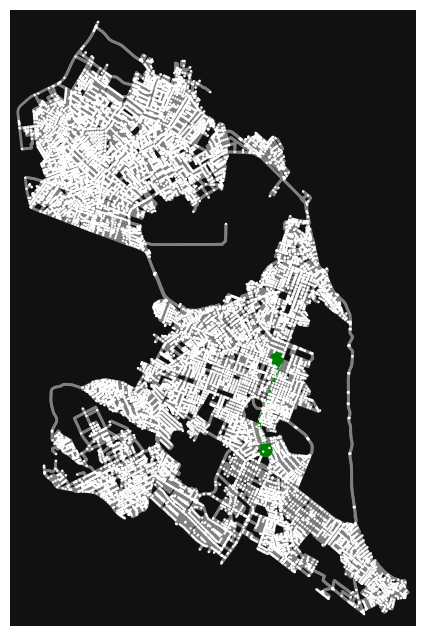

Processando rota de Natal Shopping, Natal, Brazil para Praia Shopping, Natal, Brazil...


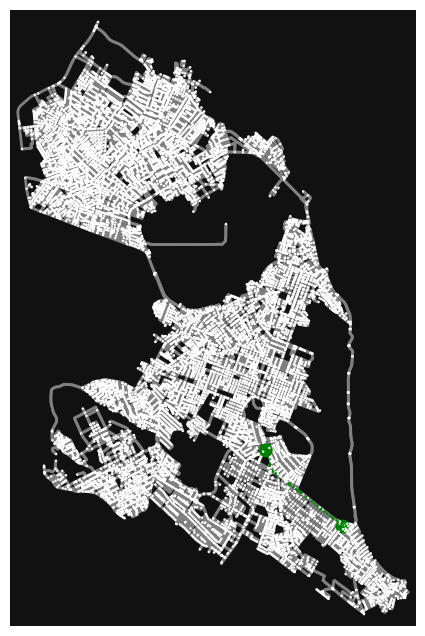

Processando rota de Midway Mall, Natal, Brazil para Arena das Dunas, Natal, Brazil...


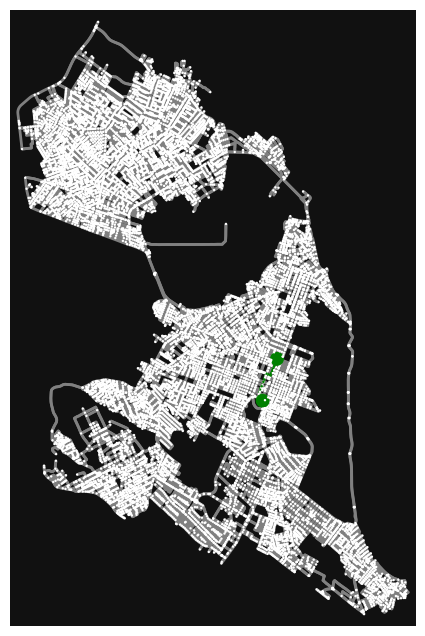

Processando rota de Arena das Dunas, Natal, Brazil para Parque das Dunas, Natal, Brazil...


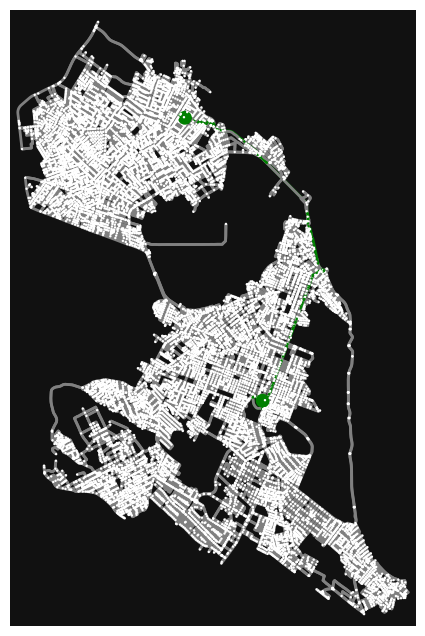

Processando rota de UFRN, Natal, Brazil para Parque das Dunas, Natal, Brazil...


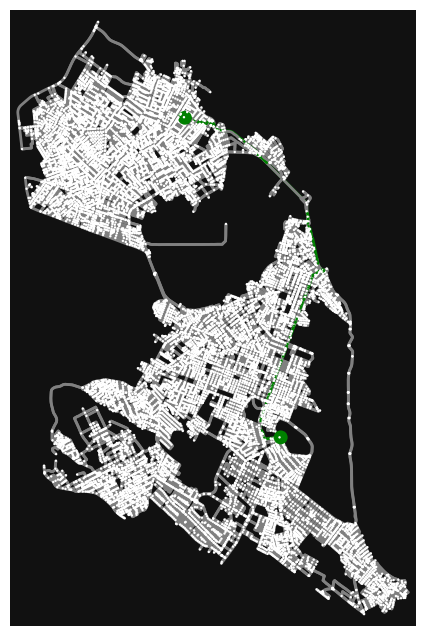

Processando rota de UFRN, Natal, Brazil para Midway Mall, Natal, Brazil...


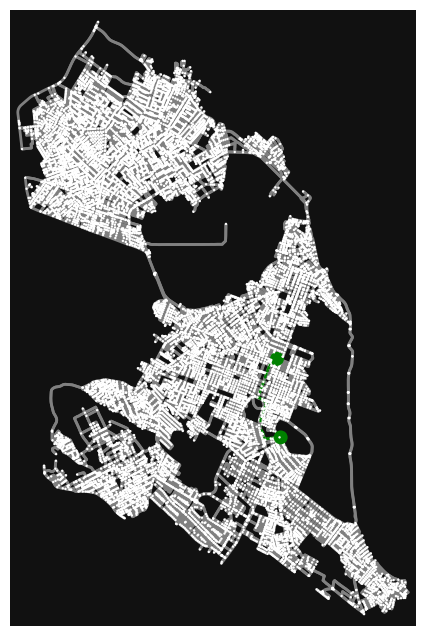

Processando rota de Praia Shopping, Natal, Brazil para UFRN, Natal, Brazil...


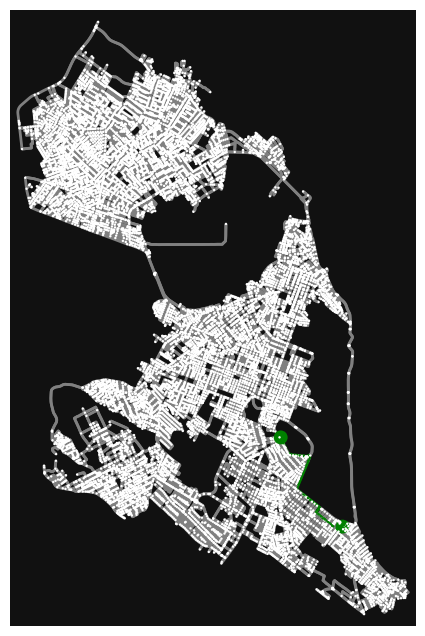

Processando rota de Leroy Merlin, Natal, Brazil para Facex, Natal, Brazil...


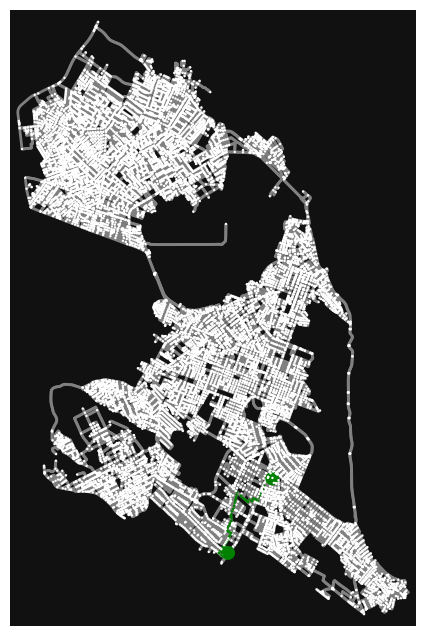

Processando rota de Hospital do Coração, Natal, Brazil para Arena das Dunas, Natal, Brazil...


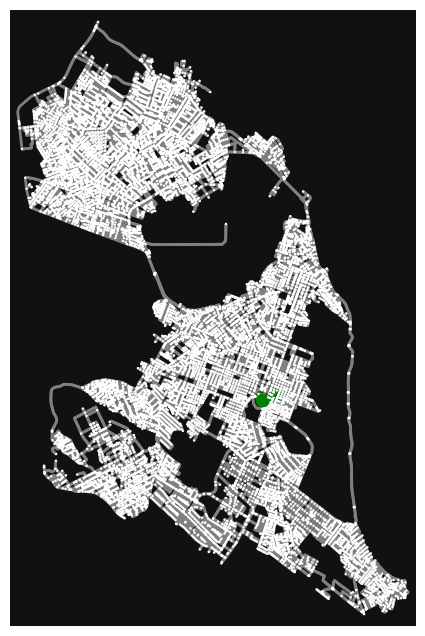

Processando rota de Arena das Dunas, Natal, Brazil para Praia Shopping, Natal, Brazil...


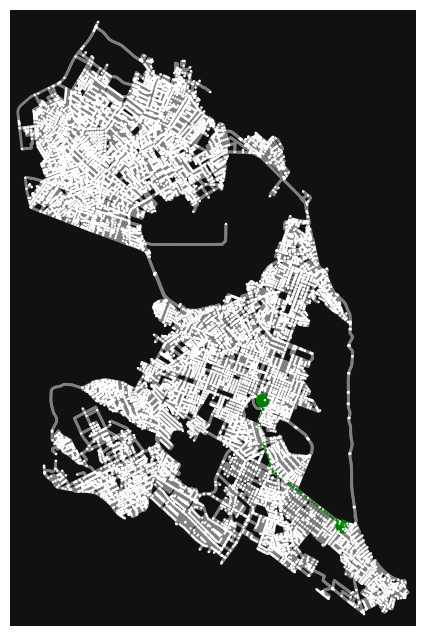

In [19]:
import osmnx as ox
import networkx as nx

# Função para gerar o grafo para dois pontos
def generate_graph_between_points(origin, destination):
    """
    Gera o grafo de rota entre dois pontos específicos usando OSMnx.

    Args:
        origin (str): Endereço ou coordenadas do ponto de origem.
        destination (str): Endereço ou coordenadas do ponto de destino.

    Returns:
        tuple: (grafo, origem_node, destino_node, rota)
    """
    # Baixar o grafo viário da cidade de Natal
    city_graph = ox.graph_from_place("Natal, Rio Grande do Norte, Brazil", network_type="drive")

    # Obter os nós mais próximos para os dois pontos
    origin_node = ox.distance.nearest_nodes(city_graph, *ox.geocoder.geocode(origin)[::-1])
    destination_node = ox.distance.nearest_nodes(city_graph, *ox.geocoder.geocode(destination)[::-1])

    # Calcular a rota entre os dois pontos
    route = nx.shortest_path(city_graph, origin_node, destination_node, weight="length")

    return city_graph, origin_node, destination_node, route

# Função para visualizar o grafo sem zoom, destacando os pontos e a rota
def visualize_route(graph, route, origin_node, destination_node):
    """
    Visualiza o grafo completo com a rota destacada entre dois pontos.

    Args:
        graph (networkx.DiGraph): Grafo da cidade.
        route (list): Lista de nós na rota.
        origin_node (int): Nó de origem.
        destination_node (int): Nó de destino.
    """
    # Destacar a rota no mapa
    route_edges = list(zip(route[:-1], route[1:]))

    # Configurar os nós e arestas destacados
    nc = ["green" if node in route else "red" if node in [origin_node, destination_node] else "white" for node in graph.nodes()]
    ec = ["green" if edge in route_edges else "gray" for edge in graph.edges()]

    # Reduzir o tamanho dos nós azuis para melhorar a visualização
    node_sizes = [100 if node in [origin_node, destination_node] else 3 for node in graph.nodes()]

    # Plotar o grafo com a rota destacada
    ox.plot_graph(
        graph,
        node_color=nc,
        edge_color=ec,
        node_size=node_sizes,
        edge_linewidth=2
    )

# Lista de pares de origem e destino
pairs = [
    ("Midway Mall, Natal, Brazil", "Natal Shopping, Natal, Brazil"),
    ("Natal Shopping, Natal, Brazil", "Praia Shopping, Natal, Brazil"),
    ("Midway Mall, Natal, Brazil", "Arena das Dunas, Natal, Brazil"),
    ("Arena das Dunas, Natal, Brazil", "Parque das Dunas, Natal, Brazil"),
    ("UFRN, Natal, Brazil", "Parque das Dunas, Natal, Brazil"),
    ("UFRN, Natal, Brazil", "Midway Mall, Natal, Brazil"),
    ("Praia Shopping, Natal, Brazil", "UFRN, Natal, Brazil"),
    ("Leroy Merlin, Natal, Brazil", "Facex, Natal, Brazil"),
    ("Hospital do Coração, Natal, Brazil", "Arena das Dunas, Natal, Brazil"),
    ("Arena das Dunas, Natal, Brazil", "Praia Shopping, Natal, Brazil")
]

# Gerar e visualizar os grafos separadamente para cada par
for origin, destination in pairs:
    print(f"Processando rota de {origin} para {destination}...")
    graph, origin_node, destination_node, route = generate_graph_between_points(origin, destination)
    visualize_route(graph, route, origin_node, destination_node)
